# ML Pipeline

V3 : simple pipeline with few features

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import pickle
import pandas as pd
import numpy as np
import geopandas as gpd
import rioxarray as rxr
from region_new import Region
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *

from ml.add_all_features import *
from ml.preprocessing import *
from ml.model import *

### ML Pipeline on Turkish Cities

##### Prepare the four cities `(skip if pickled)`

In [3]:
ordu_path = os.path.join("data", "ml", "Ordu.pkl")
manisa_path = os.path.join("data", "ml", "Manisa.pkl")
adana_path = os.path.join("data", "ml", "Adana.pkl")
trabzon_path = os.path.join("data", "ml", "Trabzon.pkl")

In [4]:
with open(ordu_path, 'rb') as f:     
    ordu = pickle.load(f)
    f.close()
with open(adana_path, 'rb') as f:     
    adana = pickle.load(f)
    f.close()
with open(manisa_path, 'rb') as f:     
    manisa = pickle.load(f)
    f.close()
with open(trabzon_path, 'rb') as f:     
    trabzon = pickle.load(f)
    f.close()

In [5]:
ordu = add_all_features(ordu,  'Ordu')
manisa = add_all_features(manisa,  'Manisa')
adana = add_all_features(adana,  'Adana')
trabzon = add_all_features(trabzon,  'Trabzon')

adding polygons... 
adding denstity... 
adding area... 
adding rasters... 
adding polygons... 
adding denstity... 
adding area... 
adding rasters... 
adding polygons... 
adding denstity... 
adding area... 
adding rasters... 
adding polygons... 
adding denstity... 
adding area... 
adding rasters... 


In [6]:
data = merge_cities([ordu, manisa, adana, trabzon])
data.isna().sum()

/home/matt/wb_cities/ml/preprocessing.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_next)
/home/matt/wb_cities/ml/preprocessing.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_next)
/home/matt/wb_cities/ml/preprocessing.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_next)


height          275043
orient          279547
type_level_0    275239
density              0
area                 0
source           41717
geometry             0
type_level_1    275461
type_level_2     42718
ntl               8490
lcz               8085
index_right       7728
wsf               7877
city                 0
dtype: int64

In [7]:
# Data Preparation for the whole country is quite long.
# So better save the result to spare some computation time
turkey_path = os.path.join("data", "ml", "Turkey.pkl")
with open(turkey_path,"wb") as f:
    pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
turkey_path = os.path.join("data", "ml", "Turkey.pkl")
with open(turkey_path,"rb") as f:
    data = pickle.load(f)

In [9]:
data = clean_columns(data)

In [10]:
train, pred = split(data)

In [11]:
X, y = training_split(train, 'height')
print(X.shape, y.shape)

(32442, 8) (32442,)


In [12]:
preprocessor = preprocesor(train)

(25953, 8) (25953,)


/home/matt/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


RandomForestClassifier(random_state=42)
Current Best Score :  0.8252995903314208


/home/matt/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


SVC(probability=True, random_state=42)
Current Best Score :  0.8252995903314208


/home/matt/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/matt/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/matt/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-

LogisticRegression(random_state=42)
Current Best Score :  0.8252995903314208


/home/matt/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


DecisionTreeClassifier(random_state=42)
Current Best Score :  0.8252996645669157


/home/matt/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


KNeighborsClassifier()
Current Best Score :  0.8474550847416735


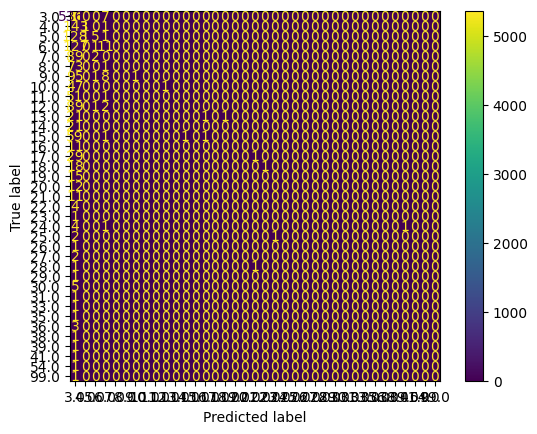

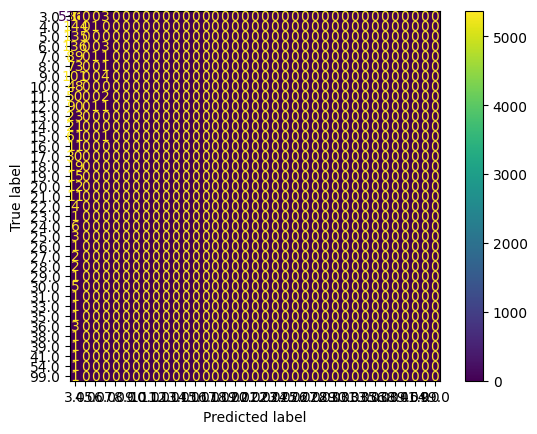

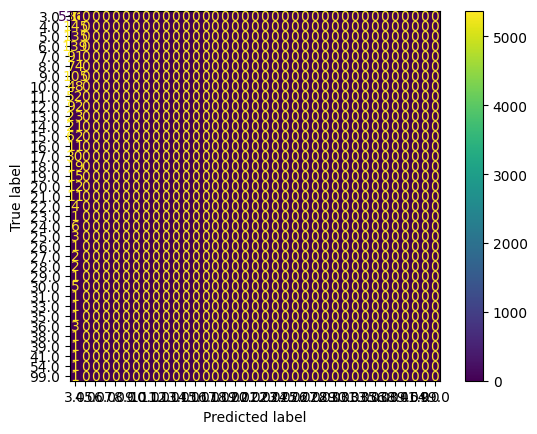

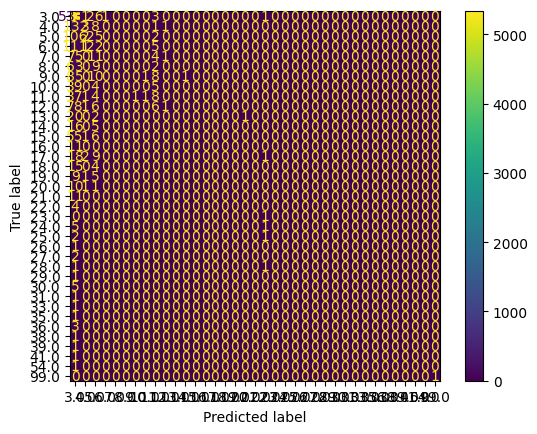

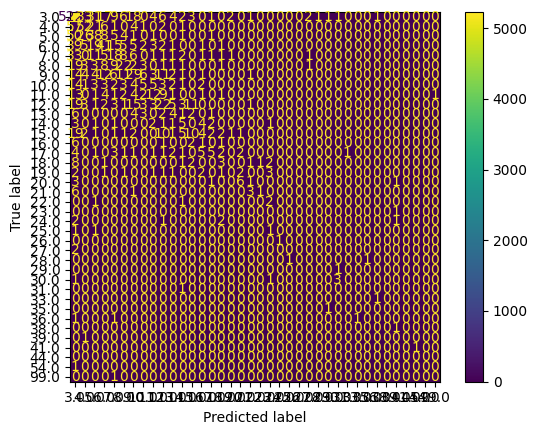

In [13]:
model = select_best_estimator(X, y, preprocessor)

In [16]:
model_path = os.path.join("data", "ml", "models", "Turkey.pkl")
with open(model_path,"wb") as f:
    pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

In [66]:
model_path = os.path.join("data", "ml", "models", "Turkey.pkl")
with open(model_path,"rb") as f:
   model = pickle.load(f)

In [67]:
turkey_path = os.path.join("data", "ml", "Turkey.pkl")
with open(turkey_path,"rb") as f:
    data = pickle.load(f)

In [68]:
prediction = predict(model, 'height', train, pred, data)

In [69]:
predictions_list = breakdown_cities(prediction)

In [70]:
for prediction in predictions_list:
    city = prediction.city.unique()[0]
    print(city)
    result = prediction_to_raster(prediction, 'height_pred')
    write_result(result, 'height', city)

Ordu
Manisa
Adana
Trabzon


##### Visual Outputs

###### 

In [71]:
ordu_path = os.path.join("data", "ml", "prediction", "height", "Ordu.tif")
manisa_path = os.path.join("data", "ml", "prediction", "height", "Manisa.tif")
adana_path = os.path.join("data", "ml", "prediction", "height", "Adana.tif")
trabzon_path = os.path.join("data", "ml", "prediction", "height", "Trabzon.tif")

In [72]:
ordu = rasterio.open(ordu_path)
manisa = rasterio.open(manisa_path)
adana = rasterio.open(adana_path)
trabzon = rasterio.open(trabzon_path)

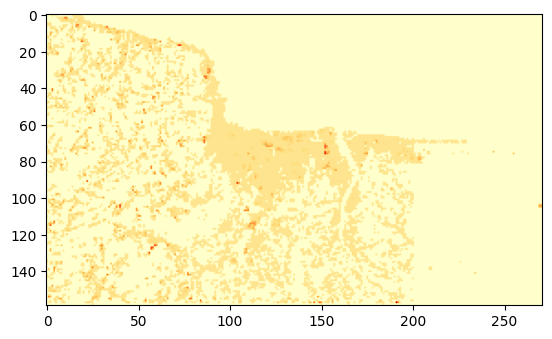

In [73]:
plt.imshow(ordu.read(1), cmap="YlOrRd")

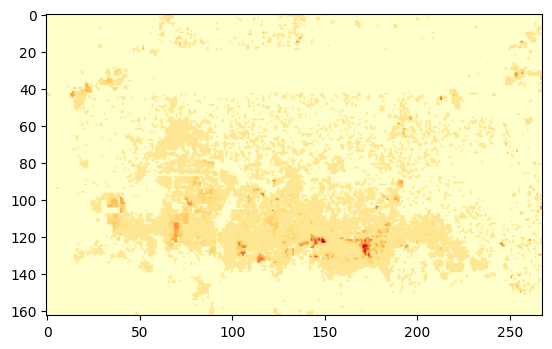

In [74]:
plt.imshow(manisa.read(1), cmap="YlOrRd")

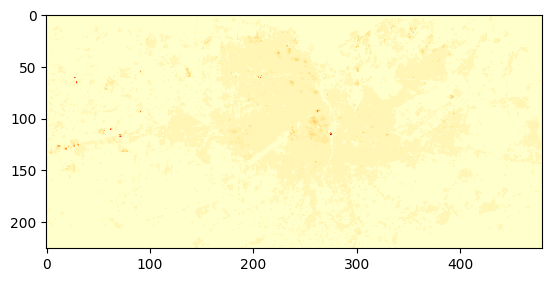

In [75]:
plt.imshow(adana.read(1), cmap="YlOrRd")

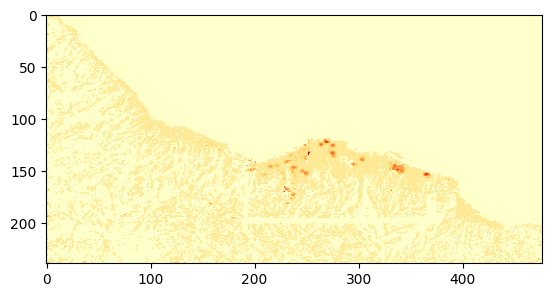

In [76]:
plt.imshow(trabzon.read(1), cmap="YlOrRd")